## Directory definition

In [ ]:
train_dir = "./train"
train_oversampled_dir = "./train_oversampled"
val_dir = "./val"

## Important:
ConvexNeXt large is an extremly heavy model, thus we were not able to perform Transfer learning and Fine tuning on the same session without getting kaggle's RAM exploding.
For this reason, we opened a first session to perform Transfer learning and saved the model.
Finally, we opened a second session running the Fine tuning cells, loading the model got through Transfer learning.

In [1]:
import tensorflow as tf


import keras
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import time



tfk = tf.keras
tfkl = tf.keras.layers


# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Warning: no GPU is running")

Default GPU Device: /device:GPU:0


2022-11-23 15:09:54.410521: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 15:09:54.785879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 15:09:54.786732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 15:09:54.932098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# COMPUTING WEIGHTS


computing weights for the weighted loss function. Less frequent are samples from a given category, the higher will be the penalty on missing the correct label.
We could not see any improvement using these weights in all of our experiments, thus we do not use this method in this notebook.

In [ ]:
labels = os.listdir(train_dir)
labels.sort()
counts = []
weights = {}
for label in labels:
    counts.append(len(os.listdir(f"{train_dir}/{label}")))
total = sum(counts)

for index, c in enumerate(counts):
    weights[index] = (1 / c) * (total / 8.0)
weights

# SELF ENSEMBLING

Methods used for self ensembling.
- tune_inference_augmentation is responsible of turning off the infference mode to the augmentation layers
- self_ensembling_predict() method perform multiple predictions on the same validation set (that is augmented by the augmentation layer) allowing to perform self-ensembling.
Unfortunally, we were not able to increase the performances with self-enseble.

In [2]:
def tune_inference_augmentation(model, activate):
    """
    This method is responsible for turning on or off the inference mode to the augmentation layers of
    a given model.
    :param model: model whose augmentation layers must be turn
    :param activate: boolean value. If True, activate inference mode, otherwise, 
    turn off inference mode.
    :retrun: None
    """
    for l in model.layers:
        if type(l) in [tfkl.RandomFlip, tfkl.RandomContrast, tfkl.RandomRotation]:
            l.inference=activate

def self_ensembling_predict(model, validation, voters=5):
    """
    This method perform a self ensemble prediction. First, it disactivates the inference mode
    for the augmentation layers of the model. Given a number of voters, it runs "voters" predictions.
    Finally averages the answers and gives the argmax for each prediction.
    :param model: model for the predictions.
    :param validation: dataset object to use for the prediction.
    :param voters: number of predictions to run.
    :return a tensor containing all the predictions over validation.
    """
    # activating augmentation at inference
    tune_inference_augmentation(model, activate=False)
    y_predicted = []
    for _ in range(voters):
        y_predicted.append(model.predict(validation))
    y_predicted = np.array(y_predicted)
    y_predicted = np.mean(y_predicted, axis=0)
    y_predicted = tf.argmax(y_predicted, axis=1)
    tune_inference_augmentation(model, activate=True)
    return y_predicted
        

In [3]:
def build_heatmap(model, validation_generator, ensemble=False):
    """
    This method generates an heatmap used by seaborn to create a confusion matrix.
    :param model: model for which the method computes the confusion matrix.
    :param validation_generator: dataset object over which the model computes its predictions.
    :param ensemble: Optional argument. If ensemble is True, it computes the confusion matrix using
    a selfe-ensemble method with 5 voters.
    :return pd.DataFrame object containing the confusion matrix.
    """
    if ensemble:
        y_predicted = self_ensembling_predict(model, validation_generator, voters=5)
    else:
        y_predicted = model.predict(validation_generator)
        y_predicted = tf.argmax(y_predicted, axis=1)
    y_test_labels = np.concatenate([y for x, y in validation_generator], axis=0)
    y_test_labels = tf.argmax(y_test_labels, axis=1)
    confusion_matrix = tf.math.confusion_matrix(
        y_test_labels, 
        y_predicted,
        num_classes=8
    )
    c = []
    for item in confusion_matrix:
        c.append(np.around(item / np.sum(item), decimals=3))
    df_heatmap = pd.DataFrame(c)
    return df_heatmap


# EFFICIENT PIPELINE

The following function is used to load the images in dataset objects. Keras recommend to use Dataset objects to avoid data loading being the bottleneck while training. This implementation allows us to exploit the maximum performances from GPUs.

Furthermore, to increase the training speed, we use:
- prefetch() method to read the next batch while processing the current batch;
- cache() to keep the maximum amount of data in cache to limit the number of times we have to read files.

In [4]:

def prepare_batches(
    TRAINING_DATA_DIR, VALID_DATA_DIR, 
    IMAGE_SHAPE, BATCH_SIZE
):
    autotune = tf.data.AUTOTUNE
    train = tf.keras.utils.image_dataset_from_directory(TRAINING_DATA_DIR,
                                                               labels="inferred",
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMAGE_SHAPE,
                                                               shuffle=True
                                                               ).prefetch(buffer_size=autotune).cache()
    valid =  tf.keras.utils.image_dataset_from_directory(VALID_DATA_DIR,
                                                               labels="inferred",
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMAGE_SHAPE,
                                                               shuffle=True
                                                               ).prefetch(buffer_size=autotune).cache()
    return train, valid


In [4]:
def build_model(num_classes, input_shape, n_layers=1, augmentation=True, n_neurons=10, dropout=0, activation="relu"):
    model = tfk.models.Sequential()

    # preprocessing layers:  
    if augmentation:
        model.add(tfkl.RandomFlip(mode='horizontal_and_vertical'))
        model.add(tfkl.RandomRotation(0.5))
        #model.add(tfkl.RandomZoom(0.1))
        #model.add(tfkl.RandomContrast(factor=0.2))
        model.add(tfkl.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect"))
    
    # since convexnext large was not implemented in tensorflow 2.6 (used by kaggle) and by upgrading tf to the latest version we
    # could not use GPUs anymore, we downloaded the model locally (with tensorflow latest version) und uploaded it on kaggle.
    # feature_extractor = tf.keras.models.load_model("../input/convexnet/convexnet/large") 
    feature_extractor = tf.keras.applications.convnext.ConvNeXtXLarge(include_top=False,
                                                                      include_preprocessing=True,
                                                                      input_shape=(96, 96, 3))
    feature_extractor.trainable = False
    
    # fully connected stack
    model.add(feature_extractor)
    model.add(tfkl.Flatten())

    model.add(tfkl.Dropout(dropout))
    model.add(tfkl.Dense(256, activation=activation, kernel_initializer=tfk.initializers.HeUniform(seed)))
    model.add(tfkl.Dropout(dropout))
    model.add(tfkl.Dense(128, activation=activation, kernel_initializer=tfk.initializers.HeUniform(seed)))
    model.add(tfkl.Dropout(dropout))
    model.add(tfkl.Dense(64, activation=activation, kernel_initializer=tfk.initializers.HeUniform(seed)))
    model.add(tfkl.Dropout(dropout))
    model.add(tfkl.Dense(32, activation=activation, kernel_initializer=tfk.initializers.HeUniform(seed)))
    
    model.add(tfkl.Dropout(dropout))
    model.add(tfkl.Dense(num_classes, activation="softmax", kernel_initializer=tfk.initializers.GlorotUniform(seed)))
    return model

# Hyperparametes

In [5]:
input_shape = (96, 96, 3)
IMAGE_SHAPE = (96, 96) 
TRAINING_DATA_DIR = train_oversampled_dir
VALID_DATA_DIR = val_dir
BATCH_SIZE = 512
EPOCHS = 300
lr = 1e-3

# Transfer learning with ConvexNext Large

We used kaggle to perform our training process. Since Kaggle provides us with 2 GPUs, we exploit both of them using the mirrored strategy.

In [5]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

2022-11-23 15:10:20.895163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 15:10:20.896483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 15:10:20.897628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 15:10:20.898745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 15:10:20.899920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [ ]:

with mirrored_strategy.scope():
    # Prepare the data batches.
    train_batches, valid_batches = prepare_batches(
        TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, BATCH_SIZE
    )
    # Prepare and compile the model.
    model = build_model(num_classes=8,
                        input_shape=input_shape,
                        augmentation=True,
                        n_layers=1,
                        n_neurons=256,
                        dropout=0.1,
                        activation="swish"
                       )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    # TRAINING PHASE
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, monitor="val_accuracy", restore_best_weights=True)
        
    history = model.fit(
        train_batches,
        epochs=EPOCHS,
        validation_data=valid_batches,
        verbose=1,
        workers=4,
        use_multiprocessing=True,
        callbacks=[early_stopping]
    )

In [ ]:
x_axis = len(history.history["accuracy"])
print(max(history.history["val_accuracy"]), max(history.history["accuracy"]))
history.history.keys()
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(x_axis)], history.history["accuracy"],  color="blue", label="train accuracy")
plt.plot([i for i in range(x_axis)], history.history["val_accuracy"], color="red", label="validation accuracy")
plt.plot([np.argmax(history.history["val_accuracy"])],
         [max(history.history["val_accuracy"])],
         marker="o",
         markeredgecolor="red",
         markerfacecolor="red",
         label="best model",
         markersize=10
        )
plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Cross entropy")
plt.plot([i for i in range(x_axis)], history.history["loss"],  color="blue", label="train cross entropy")
plt.plot([i for i in range(x_axis)], history.history["val_loss"], color="red", label="validation cross entropy")
plt.plot([np.argmin(history.history["val_loss"])],
         [min(history.history["val_loss"])],
         marker="o",
         markeredgecolor="red",
         markerfacecolor="red",
         label="best model",
         markersize=10
        )
plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Cross entropy")
plt.show()

In [ ]:
plt.figure(figsize=(8, 7))
df = build_heatmap(model, valid_batches)
sns.heatmap(df, annot=True, cmap="crest")
plt.plot()

In [ ]:
plt.figure(figsize=(8, 7))
df = build_heatmap(model, valid_batches, ensemble=True)
sns.heatmap(df, annot=True, cmap="crest")
plt.plot()

In [ ]:
model.save(f"models/ConvexNet_transfer_learning_Best")

# Fine tuning
Since there are too much abstract features that may not fit with our images we want to drop the last layers

In [ ]:
del model; gc.collect()

In [7]:
input_shape = (96, 96, 3)
IMAGE_SHAPE = (96, 96) # For resizing
TRAINING_DATA_DIR = train_oversampled_dir
VALID_DATA_DIR = val_dir
BATCH_SIZE = 512
EPOCHS = 300

In [9]:
EPOCHS = 300


with mirrored_strategy.scope():
    # TRAINING PHASE 
    train_batches, valid_batches = prepare_batches(
        TRAINING_DATA_DIR, VALID_DATA_DIR, IMAGE_SHAPE, 512
    )    
    
    
    model_fined = tf.keras.models.load_model(f"../input/convexnet90/models/ConvexNet_transfer_learning_Best")
    
    # find the index in the model referring to the convexnext part.
    fe_index = None
    for ind, l in enumerate(model_fined.layers):
        if type(l) == keras.engine.functional.Functional:
            fe_index = ind

    freeze_from = 150
    print(f"freeze from {freeze_from}")
    
    # unfreeze layers
    model_fined.layers[fe_index].trainable=True
    
    # freeze remainig layers 
    for l in model_fined.layers[fe_index].layers[:freeze_from]:
        l.trainable = False
        
    # freeze all batch normalization layers
    for l in model_fined.layers[fe_index].layers:
        if type(l) == tfkl.BatchNormalization:
            l.trainable = False
    
    # Compile the model
    model_fined.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, monitor="val_accuracy", restore_best_weights=True)
    history = model_fined.fit(
        train_batches,
        epochs=EPOCHS,
        validation_data=valid_batches,
        verbose=1,
        workers=4,
        use_multiprocessing=True,
        callbacks=[early_stopping]
    )

Found 3362 files belonging to 8 classes.
Found 705 files belonging to 8 classes.
freeze from 150


2022-11-23 15:15:03.664864: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8968

2022-11-23 15:16:17.093237: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



7/7 [==============================] - 88s 6s/step - loss: 0.3002 - accuracy: 0.8968 - val_loss: 0.3883 - val_accuracy: 0.8809
Epoch 2/300
7/7 [==============================] - 22s 3s/step - loss: 0.2579 - accuracy: 0.9149 - val_loss: 0.3741 - val_accuracy: 0.8865
Epoch 3/300
7/7 [==============================] - 23s 3s/step - loss: 0.2212 - accuracy: 0.9280 - val_loss: 0.3640 - val_accuracy: 0.8879
Epoch 4/300
7/7 [==============================] - 23s 3s/step - loss: 0.2203 - accuracy: 0.9295 - val_loss: 0.3674 - val_accuracy: 0.8922
Epoch 5/300
7/7 [==============================] - 24s 3s/step - loss: 0.1875 - accuracy: 0.9346 - val_loss: 0.3745 - val_accuracy: 0.8965
Epoch 6/300
7/7 [==============================] - 24s 3s/step - loss: 0.2082 - accuracy: 0.9313 - val_loss: 0.3632 - val_accuracy: 0.8879
Epoch 7/300
7/7 [==============================] - 24s 3s/step - loss: 0.1757 - accuracy: 0.9402 - val_loss: 0.3687 - val_accuracy: 0.8894
Epoch 8/300
7/7 [======================

0.9290780425071716 0.9991076588630676


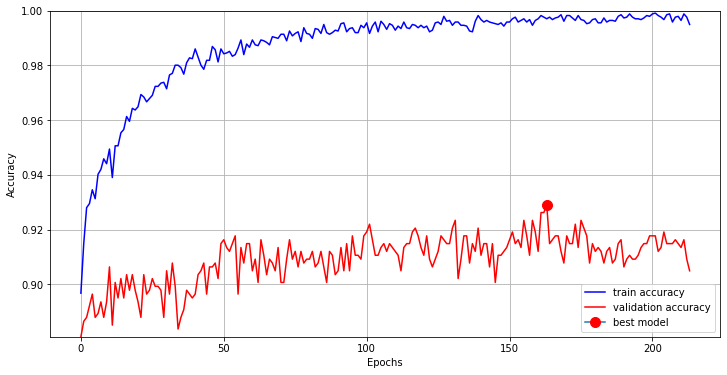

In [10]:
x_axis = len(history.history["accuracy"])
print(max(history.history["val_accuracy"]), max(history.history["accuracy"]))
history.history.keys()
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(x_axis)], history.history["accuracy"],  color="blue", label="train accuracy")
plt.plot([i for i in range(x_axis)], history.history["val_accuracy"], color="red", label="validation accuracy")
plt.plot([np.argmax(history.history["val_accuracy"])],
         [max(history.history["val_accuracy"])],
         marker="o",
         markeredgecolor="red",
         markerfacecolor="red",
         label="best model",
         markersize=10
        )
plt.axhline(y=0.88, color='green', linestyle='-')
plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
minimum = min(min(history.history["accuracy"]), min(history.history["val_accuracy"]))
plt.ylim([minimum, 1])
plt.show()

2022-11-23 16:53:15.366781: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



[]

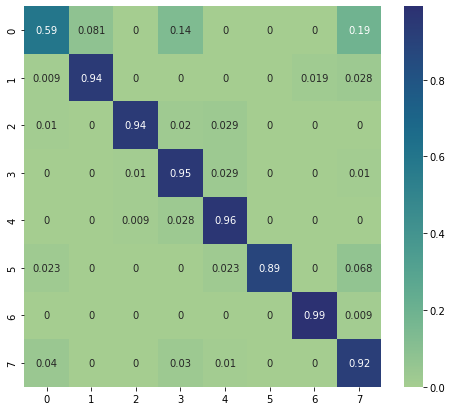

In [11]:
plt.figure(figsize=(8, 7))
df = build_heatmap(model_fined, valid_batches)
sns.heatmap(df, annot=True, cmap="crest")
plt.plot()

In [ ]:
model_fined.save(f"models/ConvexNet_fined_Best")

2022-11-23 17:10:12.703328: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Confusion matrix for self-ensemble method.
It does not change anything...

2022-11-23 16:53:43.458328: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}

2022-11-23 16:53:45.930910: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
 

[]

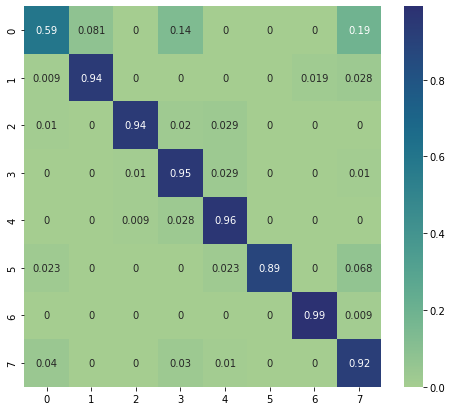

In [12]:
plt.figure(figsize=(8, 7))
df = build_heatmap(model_fined, valid_batches, ensemble=True)
sns.heatmap(df, annot=True, cmap="crest")
plt.plot()